<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import plotly.express as px

First, some basic functions.

In [2]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [3]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [4]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

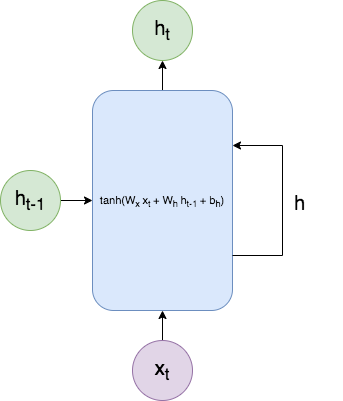

In [5]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [6]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

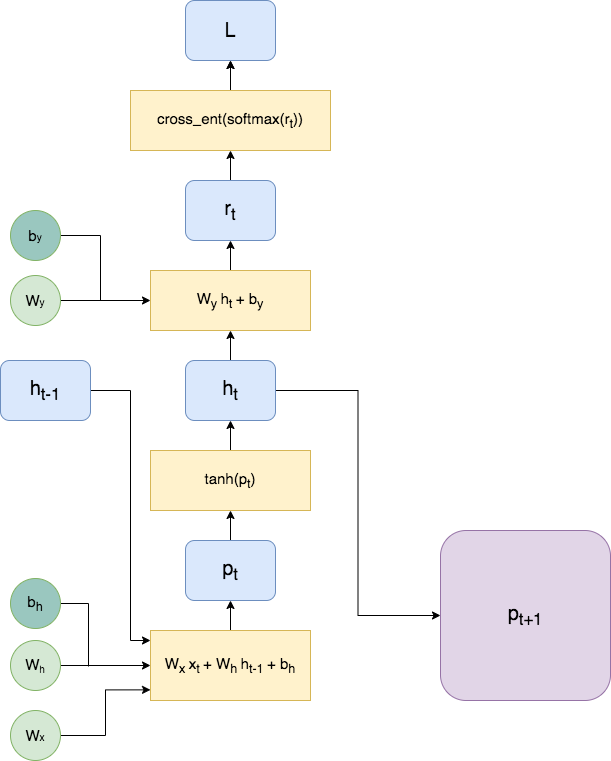

In [7]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [8]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [9]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

2.195187436534164
0.05264779545267647
0.027083977090621006
0.018390188795228617
0.013906514821994639
0.0111566187713095
0.009298539662525713
0.007961298045880397
0.0069545591967954375
0.00617035527656213


In [10]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [39]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset = tfds.load(name='tiny_shakespeare')['train']
dataset = dataset.map(lambda x: tf.strings.unicode_split(x['text'], 'UTF-8'))
dataset = dataset.unbatch()

In [12]:
def one_hot(k):
    enc = np.zeros((256, 1))
    enc[k, 0] = 1
    return enc

In [13]:
def xavier(shape):
    width = 1 / np.sqrt(shape[-1])
    return np.random.uniform(-width, width, size=shape)

In [14]:
hidden_dim = 64
vocab_size = 256
size = 25
alpha = 0.001
num_epochs = 3
mu = 0.5

In [15]:
Wx = xavier((hidden_dim, vocab_size))

Wh = xavier((hidden_dim, hidden_dim))
bh = xavier((hidden_dim, 1))

Wy = xavier((vocab_size, hidden_dim))
by = xavier((vocab_size, 1))

In [16]:
v_Wx = np.zeros_like(Wx)

v_Wh = np.zeros_like(Wh)
v_bh = np.zeros_like(bh)

v_Wy = np.zeros_like(Wy)
v_by = np.zeros_like(by)

In [17]:
i = 0
losses = []

for epoch in range(num_epochs):
    if i > 100_000:
        break

    for record in dataset.batch(1):
        if i > 100_000:
            break

        line = list(record['text'].numpy()[0])

        hzero = np.zeros_like(bh)

        for t in range(0, len(line) - size - 1):
            if i > 100_000:
                break

            xs = line[t:t + size]
            xs = [one_hot(k) for k in xs]

            ts = line[t + 1:t + size + 1]

            ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
            hs.append(hzero)

            if i % 5000 == 0:
                losses.append(loss_fn(ts, ys))
                print(f"Loss at step {i}: {losses[-1]}")

            dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

            v_Wy = mu * v_Wy - alpha * dWy
            Wy += v_Wy

            v_by = mu * v_by - alpha * dby
            by += v_by

            v_Wx = mu * v_Wx - alpha * dWx
            Wx += v_Wx

            v_Wh = mu * v_Wh - alpha * dWh
            Wh += v_Wh

            v_bh = mu * v_bh - alpha * dbh
            bh += v_bh

            hzero = hs[-2]  # the last h_t will be the next hzero
            i += 1

Loss at step 0: 5.989067792130572
Loss at step 5000: 1.7692114952812785
Loss at step 10000: 2.2027105232987165
Loss at step 15000: 1.5156128862888445
Loss at step 20000: 1.5755107310524645
Loss at step 25000: 1.9239472147485355
Loss at step 30000: 2.12366959609361
Loss at step 35000: 1.7215182939461864
Loss at step 40000: 2.020043168647008
Loss at step 45000: 1.9741320930722406
Loss at step 50000: 1.9632952998957496
Loss at step 55000: 2.0181869711087184
Loss at step 60000: 2.313880345391334
Loss at step 65000: 1.9208991726685627
Loss at step 70000: 2.1890869377410382
Loss at step 75000: 1.6675887801278537
Loss at step 80000: 1.1735087022381132
Loss at step 85000: 0.9408181439769308
Loss at step 90000: 2.341228390213021
Loss at step 95000: 2.177699979227682
Loss at step 100000: 2.220838765833337
Loss at step 105000: 1.8383283729904472
Loss at step 110000: 2.3785981777020124
Loss at step 115000: 2.2337991874537564
Loss at step 120000: 2.084416583137848
Loss at step 125000: 2.32006406471

KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)),
                   'Loss': losses,
                   'Running Avg Loss': np.convolve(losses, np.ones(10)/10, mode='valid')})

fig = px.line(df, x="Step", y="Loss")
fig = px.line(df, x="Step", y="Running Avg Loss")
fig.show()

In [23]:
h = np.zeros_like(bh)
sentence = ['T']
x = ord(sentence[0])

for _ in range(140):
    h = rnn_cell(one_hot(x), h, Wx, Wh, bh)
    y = softmax(Wy @ h + by)

    x = np.random.choice(range(256), p=y[:, 0])
    sentence.append(chr(x))

print("".join(sentence))

T
  T T T  T                                                                                                                                 


In [43]:
j = 0

for record in dataset.batch(25):
    j += 1
    print([ord(c) for c in record.numpy()])
    if j > 10:
        break

[70, 105, 114, 115, 116, 32, 67, 105, 116, 105, 122, 101, 110, 58, 10, 66, 101, 102, 111, 114, 101, 32, 119, 101, 32]
[112, 114, 111, 99, 101, 101, 100, 32, 97, 110, 121, 32, 102, 117, 114, 116, 104, 101, 114, 44, 32, 104, 101, 97, 114]
[32, 109, 101, 32, 115, 112, 101, 97, 107, 46, 10, 10, 65, 108, 108, 58, 10, 83, 112, 101, 97, 107, 44, 32, 115]
[112, 101, 97, 107, 46, 10, 10, 70, 105, 114, 115, 116, 32, 67, 105, 116, 105, 122, 101, 110, 58, 10, 89, 111, 117]
[32, 97, 114, 101, 32, 97, 108, 108, 32, 114, 101, 115, 111, 108, 118, 101, 100, 32, 114, 97, 116, 104, 101, 114, 32]
[116, 111, 32, 100, 105, 101, 32, 116, 104, 97, 110, 32, 116, 111, 32, 102, 97, 109, 105, 115, 104, 63, 10, 10, 65]
[108, 108, 58, 10, 82, 101, 115, 111, 108, 118, 101, 100, 46, 32, 114, 101, 115, 111, 108, 118, 101, 100, 46, 10, 10]
[70, 105, 114, 115, 116, 32, 67, 105, 116, 105, 122, 101, 110, 58, 10, 70, 105, 114, 115, 116, 44, 32, 121, 111, 117]
[32, 107, 110, 111, 119, 32, 67, 97, 105, 117, 115, 32, 77, 97, 

ValueError: ignored